In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import operator 
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [0]:
train_df = pd.read_csv(r'drive/My Drive/final_cleaned_df.csv')

In [7]:
train_df.head()

,qid,target,final_cleaned_text
0,00002165364db923c7e6,0,how did quebec nationalists see their province...
1,000032939017120e6e44,0,do you have an adopted dog how would you encou...
2,0000412ca6e4628ce2cf,0,why does velocity affect time does velocity af...
3,000042bf85aa498cd78e,0,how did otto von guericke used the magdeburg h...
4,0000455dfa3e01eae3af,0,can i convert montra helicon d to a mountain b...


In [0]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras

Using TensorFlow backend.


In [0]:
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 60
VALIDATION_SPLIT = 0.30

In [12]:
train_df['final_cleaned_text'].head()

0    how did quebec nationalists see their province...
1    do you have an adopted dog how would you encou...
2    why does velocity affect time does velocity af...
3    how did otto von guericke used the magdeburg h...
4    can i convert montra helicon d to a mountain b...
Name: final_cleaned_text, dtype: object

In [13]:
tokenizer = Tokenizer(oov_token='OOV_TOKEN')
tokenizer.fit_on_texts(train_df['final_cleaned_text'].values)
sequences = tokenizer.texts_to_sequences(train_df['final_cleaned_text'].values)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

labels = train_df['target'].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(train_df.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


Found 178708 unique tokens.
Shape of data tensor: (1306122, 60)
Shape of label tensor: (1306122,)


In [0]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def load_embed(file):    
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [15]:
%%time
print("Extracting GloVe embedding")
embed_glove = load_embed('glove.840B.300d.txt')

Extracting GloVe embedding
CPU times: user 2min 37s, sys: 4.27 s, total: 2min 42s
Wall time: 2min 41s


In [16]:
print(len(embed_glove))

2196017


In [0]:
from tqdm import tqdm

In [0]:
EMBEDDING_DIM = 300

In [19]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tqdm(word_index.items()):
    embedding_vector = embed_glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 178708/178708 [00:00<00:00, 426164.55it/s]


In [20]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Dropout, Bidirectional
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

In [0]:
# code :: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-
# and-recall-for-a-keras-model
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

<b>Cyclic Learning Rate:</b>
Orginal blog post :: https://www.fast.ai/2018/08/10/fastai-diu-imagenet/
<br/><br/>
Keras implementaion Source code :: https://www.kaggle.com/dude431/keras-cyclic-lr
<br/><br/>
<b>Other references</b>
https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee

In [0]:
from keras.callbacks import Callback
from keras import backend as K

class CyclicLR(Callback):
    def __init__(
            self,base_lr=0.001,
            max_lr=0.006,step_size=2000.,
            mode='triangular',gamma=1.,
            scale_fn=None,scale_mode='cycle'):
        
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2','exp_range']:
            raise KeyError("mode must be one of 'triangular', "
                           "'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)


<b>References</b><br/>
https://machinelearningmastery.com/attention-long-short-term-memory-recurrent-neural-networks/
<br/><br/>
<b>Keras implementation</b><br/>
https://www.kaggle.com/qqgeogor/keras-lstm-attention-glove840b-lb-0-043

<b>Attention Layer</b>

Lets take a look at previous coventions like CountVectorizer and TFIDF Vectorizer to extract features from text, both worked well but they have their own disadvantages in case of CountVectorizer or Bag of Words representation it only takes into account the number of times the word occured in the document thus giving more importance to a word which occured more times. TFIDF solves this issue, tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word that means it gives higher weightage to the words that occur very rare and low to more frequently occured thus TFIDF works best in most of the cases than norma bag of words but the major disadvantage is they don't consider the sequence thats where LSTM's/GRU/RNN came to place and performed very well by considering the sequence but we loose ability to give higher wieghtage to more important words. So what if we have LSTM'S/RNN/GRU have a capability to give much importance to words that are important thats where <b>Attention</b> mechanism is introduced. More details on this paper (https://arxiv.org/abs/1706.03762) and https://www.cs.cmu.edu/~./hovy/papers/16HLT-hierarchical-attention-networks.pdf.  

<img src='s1.png'/>

<img src='s2.png'/>

\begin{align}
e_{t} & = \tanh(W_a*h_t + b_a) \\
\alpha_{t} & = exp^{e_t} /(\sum_{k=1}^t exp^{e_t}) \\ 
c & = \sum_{k=1}^t \alpha_k * h_k \\ 
\end{align}

e_t :: Output at state t. <br/>
alpha_t :: Softmax(e_t).  <br/>
c_t :: alpha_t * h_t.  <br/>
c :: sum(c_t).  <br/>

In [0]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
import warnings
warnings.filterwarnings('ignore')

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim
        
        # calculate e_t
        et = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            et += self.b
        
        # apply tanh activation
        et = K.tanh(eij)
        
        # calculate exp of e_t
        a = K.exp(et)

        if mask is not None:
            a *= K.cast(mask, K.floatx())
        
        # Apply softmax
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        # calculate sum
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [25]:
model = Sequential()
model.add(embedding_layer)
model.add(Bidirectional(LSTM(64, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
model.add(Attention(MAX_SEQUENCE_LENGTH))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='elu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[get_f1])

model.summary()










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 60, 300)           53612700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 60, 128)           186880    
_________________________________________________________________
attention_1 (Attention)      (None, 128)               188       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
________________________________

In [0]:
from keras.callbacks import ModelCheckpoint

In [0]:
clr = CyclicLR(base_lr=0.001, max_lr=0.009,step_size=400, mode='triangular', gamma=0.99994)
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_get_f1', verbose=1, \
                             save_best_only=True, mode='max')

callbacks_list = [checkpoint, clr]

In [28]:
print('Train...')
model.fit(x_train, y_train,
          batch_size=2048*2,
          epochs=25,
          validation_split=0.3, callbacks=callbacks_list)

Train...


Train on 640000 samples, validate on 274286 samples
Epoch 1/25
640000/640000 [==============================] - 114s 178us/step - loss: 0.1807 - get_f1: 0.3338 - val_loss: 0.1169 - val_get_f1: 0.5577

Epoch 00001: val_get_f1 improved from -inf to 0.55773, saving model to weights-improvement.hdf5
Epoch 2/25
640000/640000 [==============================] - 111s 174us/step - loss: 0.1148 - get_f1: 0.5723 - val_loss: 0.1112 - val_get_f1: 0.5754

Epoch 00002: val_get_f1 improved from 0.55773 to 0.57539, saving model to weights-improvement.hdf5
Epoch 3/25
640000/640000 [==============================] - 111s 174us/step - loss: 0.1078 - get_f1: 0.6113 - val_loss: 0.1045 - val_get_f1: 0.6424

Epoch 00003: val_get_f1 improved from 0.57539 to 0.64237, saving model to weights-improvement.hdf5
Epoch 4/25
640000/640000 [==============================] - 111s 174us/step - loss: 0.1025 - get_f1: 0.6389 - val_loss: 0.1026 - val_get_f1: 0.6515

Epoch 00004: val_get_f1 improved from 0.64237 t

In [29]:
model.optimizer.get_config()

{'amsgrad': False,
 'beta_1': 0.8999999761581421,
 'beta_2': 0.9990000128746033,
 'decay': 0.0,
 'epsilon': 1e-07,
 'lr': 0.0024999999441206455}

In [0]:
model.load_weights('weights-improvement.hdf5')

In [36]:
score, acc = model.evaluate(x_val, y_val,
                            batch_size=2048)
print('Test Loss:', score)
print('Test F1 Score:', acc)

391836/391836 [==============================] - 30s 77us/step
Test Loss: 0.10312879059361556
Test F1 Score: 0.6746514823591312


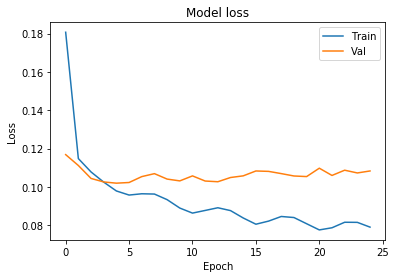

In [37]:
# Plot training & validation loss values
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

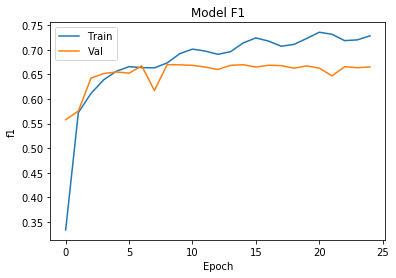

In [38]:
plt.plot(model.history.history['get_f1'])
plt.plot(model.history.history['val_get_f1'])
plt.title('Model F1')
plt.ylabel('f1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'])
plt.show()

### Conclusion

1. From figure 1 the loss of the model has not changed a lot after 5 epocs on our validation set but training loss is decreased as epochs increased.
2. From figure 2 F1 score of validation set does not change much just fluctuated between 0.64 and 0.67 but training set f1 score constantly increased upto 0.75 as number of epochs increases.
3. From the abpve figure by looking at the f1 score after 9th epoch validation set f1 score became constant and training set f1 score increased indicating the model is overfitting.
4. With bidirectional lstm using attention layer we are able to get 0.675 f1 score on our test set. 